### Import Library

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import timm
from PIL import Image
import seaborn as sns

### GPU Check

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


In [6]:
IMAGE_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Create Data

In [8]:
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

In [14]:
print("Total images:", len(dataset))
print("Number of classes:", len(dataset.classes))
class_counts = Counter([label for _, label in dataset])
for idx, count in class_counts.items():
    print(f"Class '{dataset.classes[idx]}' has {count} images")

Total images: 5400
Number of classes: 90
Class 'antelope' has 60 images
Class 'badger' has 60 images
Class 'bat' has 60 images
Class 'bear' has 60 images
Class 'bee' has 60 images
Class 'beetle' has 60 images
Class 'bison' has 60 images
Class 'boar' has 60 images
Class 'butterfly' has 60 images
Class 'cat' has 60 images
Class 'caterpillar' has 60 images
Class 'chimpanzee' has 60 images
Class 'cockroach' has 60 images
Class 'cow' has 60 images
Class 'coyote' has 60 images
Class 'crab' has 60 images
Class 'crow' has 60 images
Class 'deer' has 60 images
Class 'dog' has 60 images
Class 'dolphin' has 60 images
Class 'donkey' has 60 images
Class 'dragonfly' has 60 images
Class 'duck' has 60 images
Class 'eagle' has 60 images
Class 'elephant' has 60 images
Class 'flamingo' has 60 images
Class 'fly' has 60 images
Class 'fox' has 60 images
Class 'goat' has 60 images
Class 'goldfish' has 60 images
Class 'goose' has 60 images
Class 'gorilla' has 60 images
Class 'grasshopper' has 60 images
Class '

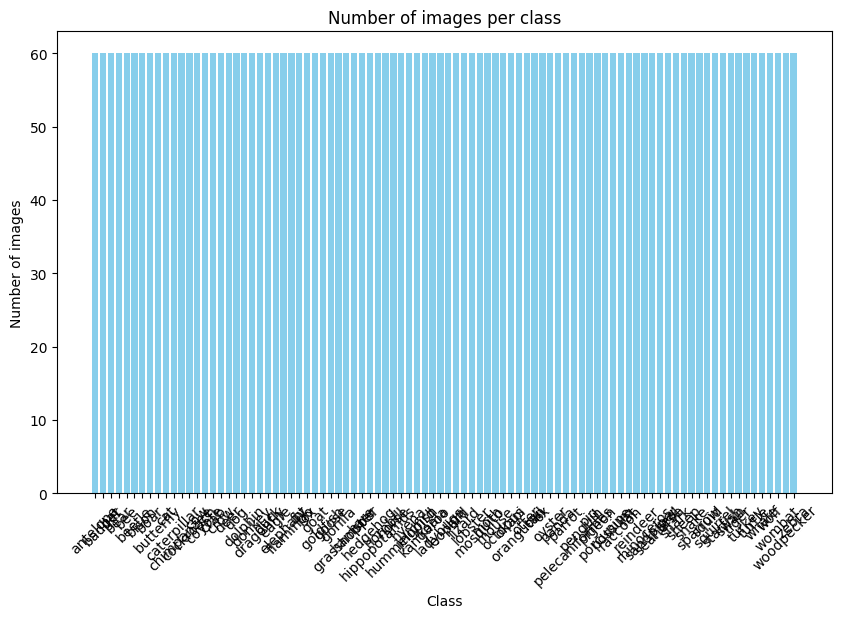

In [9]:
class_indices = [s[1] for s in dataset.samples]

counts = Counter(class_indices)

class_counts = [counts[i] for i in range(len(dataset.classes))]

plt.figure(figsize=(10, 6))
plt.bar(dataset.classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per class')
plt.xticks(rotation=45)
plt.show()

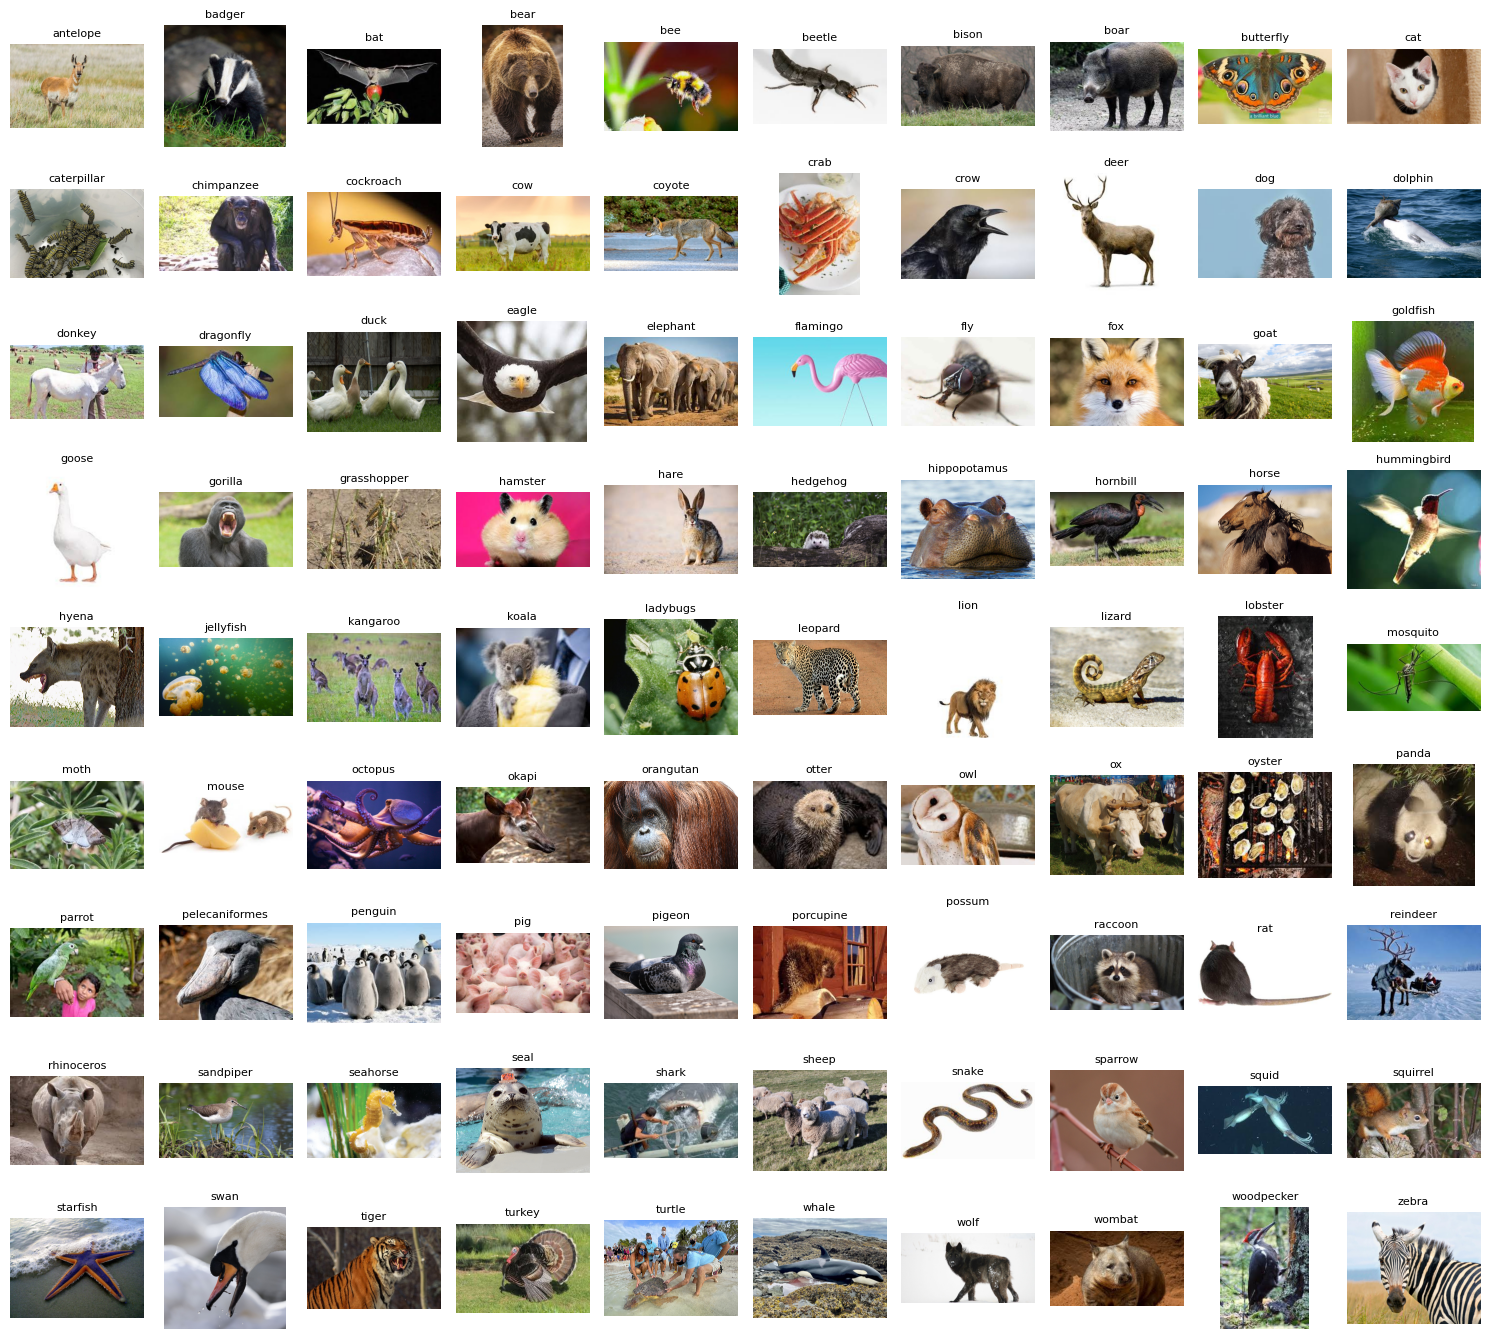

In [18]:
class_to_sample = {}
for filepath, label_idx in dataset.samples:
    class_name = dataset.classes[label_idx]
    if class_name not in class_to_sample:
        class_to_sample[class_name] = filepath

cols = 10
rows = int(np.ceil(num_classes / cols))

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 1.5),
                         subplot_kw={'xticks': [], 'yticks': []})

axes = axes.flatten()

for i, (class_name, filepath) in enumerate(class_to_sample.items()):
    image = plt.imread(filepath)
    axes[i].imshow(image)
    axes[i].set_title(class_name, fontsize=8)
    axes[i].axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Split Data

In [19]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Train dataset size:", len(train_dataset))
print("Val dataset size:", len(val_dataset))

Train dataset size: 4320
Val dataset size: 1080


### Create DataLoader

In [20]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Crate Model

In [24]:
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=True, num_classes=90)
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

### Lost Function

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True)

patience = 3
patience_counter = 0
best_val_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []

### Train One Epoch Function

In [26]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

### Evaluate Function (Loss, Accuracy and F1 Score)

In [27]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_acc, epoch_f1

### Model Train

In [29]:
NUM_EPOCHS = 30


for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    scheduler.step(val_f1)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_efficientnet2.pth")
        print("  Best model saved.")
        patience_counter = 0  # reset counter
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

model.load_state_dict(best_model_wts)

Epoch [1/30]
  Train Loss: 0.6650 | Train Acc: 81.11%
  Val Loss: 0.6602 | Val Acc: 83.43% | Val F1: 0.8332
  Best model saved.
Epoch [2/30]
  Train Loss: 0.2244 | Train Acc: 93.70%
  Val Loss: 0.5986 | Val Acc: 84.17% | Val F1: 0.8441
  Best model saved.
Epoch [3/30]
  Train Loss: 0.1171 | Train Acc: 96.97%
  Val Loss: 0.6648 | Val Acc: 83.06% | Val F1: 0.8308
Epoch [4/30]
  Train Loss: 0.1503 | Train Acc: 95.97%
  Val Loss: 0.8656 | Val Acc: 79.72% | Val F1: 0.8026
Epoch [5/30]
  Train Loss: 0.1634 | Train Acc: 95.07%
  Val Loss: 0.8163 | Val Acc: 81.39% | Val F1: 0.8152
Early stopping triggered.


<All keys matched successfully>

### Graph

In [30]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(18,5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

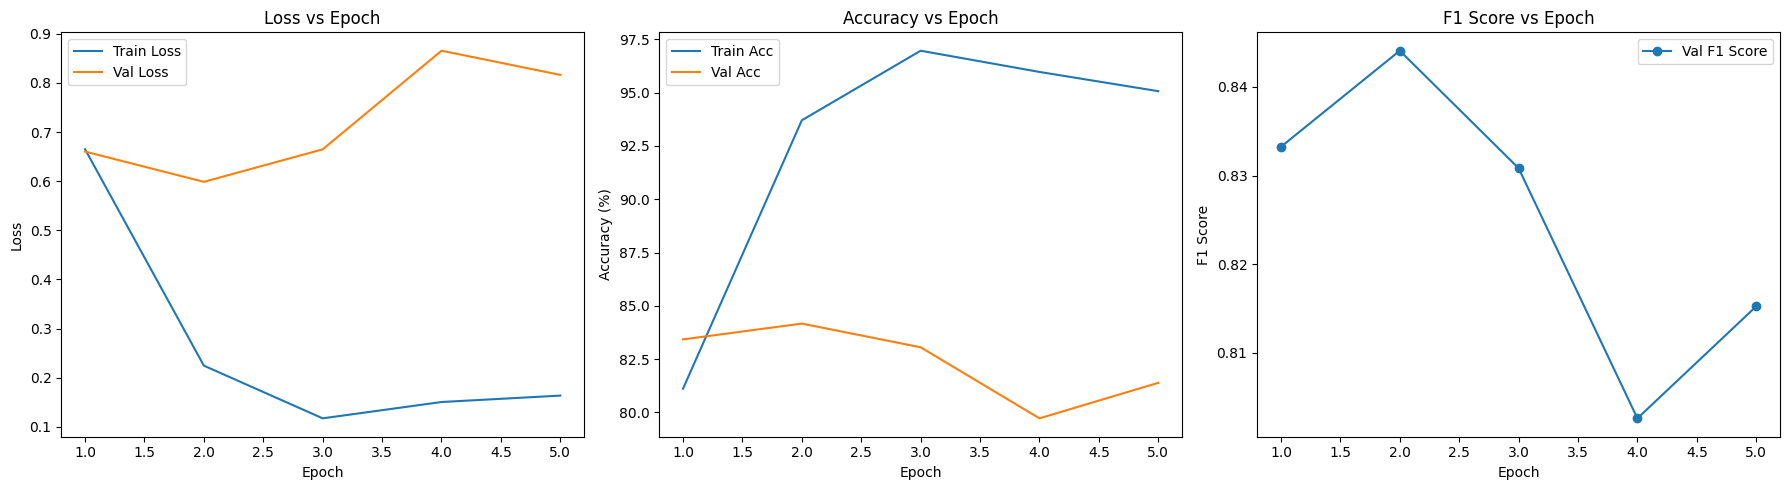

In [31]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_f1s, label="Val F1 Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

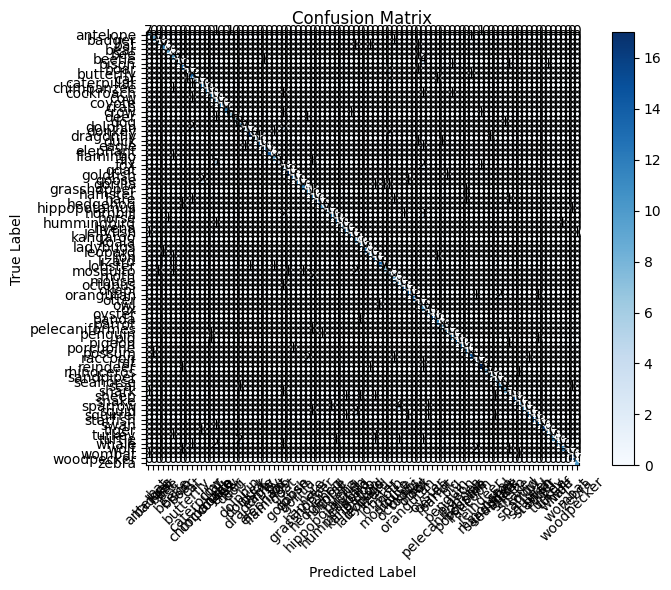

In [32]:
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# classes = train_dataset.classes
classes = dataset.classes

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

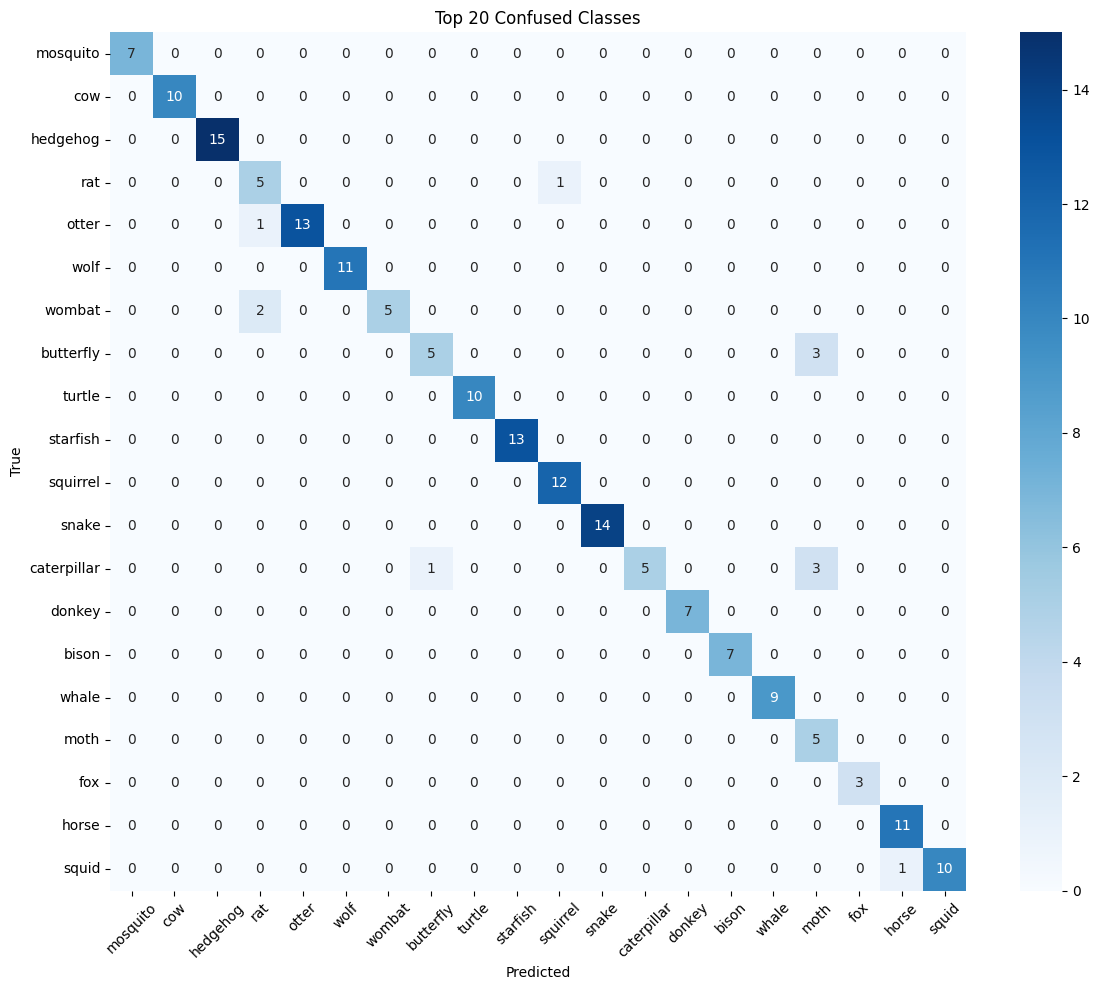

In [36]:
cm = confusion_matrix(all_labels, all_preds)

errors = cm.sum(axis=1) - np.diag(cm)

top_n = 20
top_n_idx = np.argsort(errors)[-top_n:]

cm_top = cm[top_n_idx][:, top_n_idx]
classes_top = [classes[i] for i in top_n_idx]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_top, yticklabels=classes_top)
plt.title("Top 20 Confused Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Predicted Validation

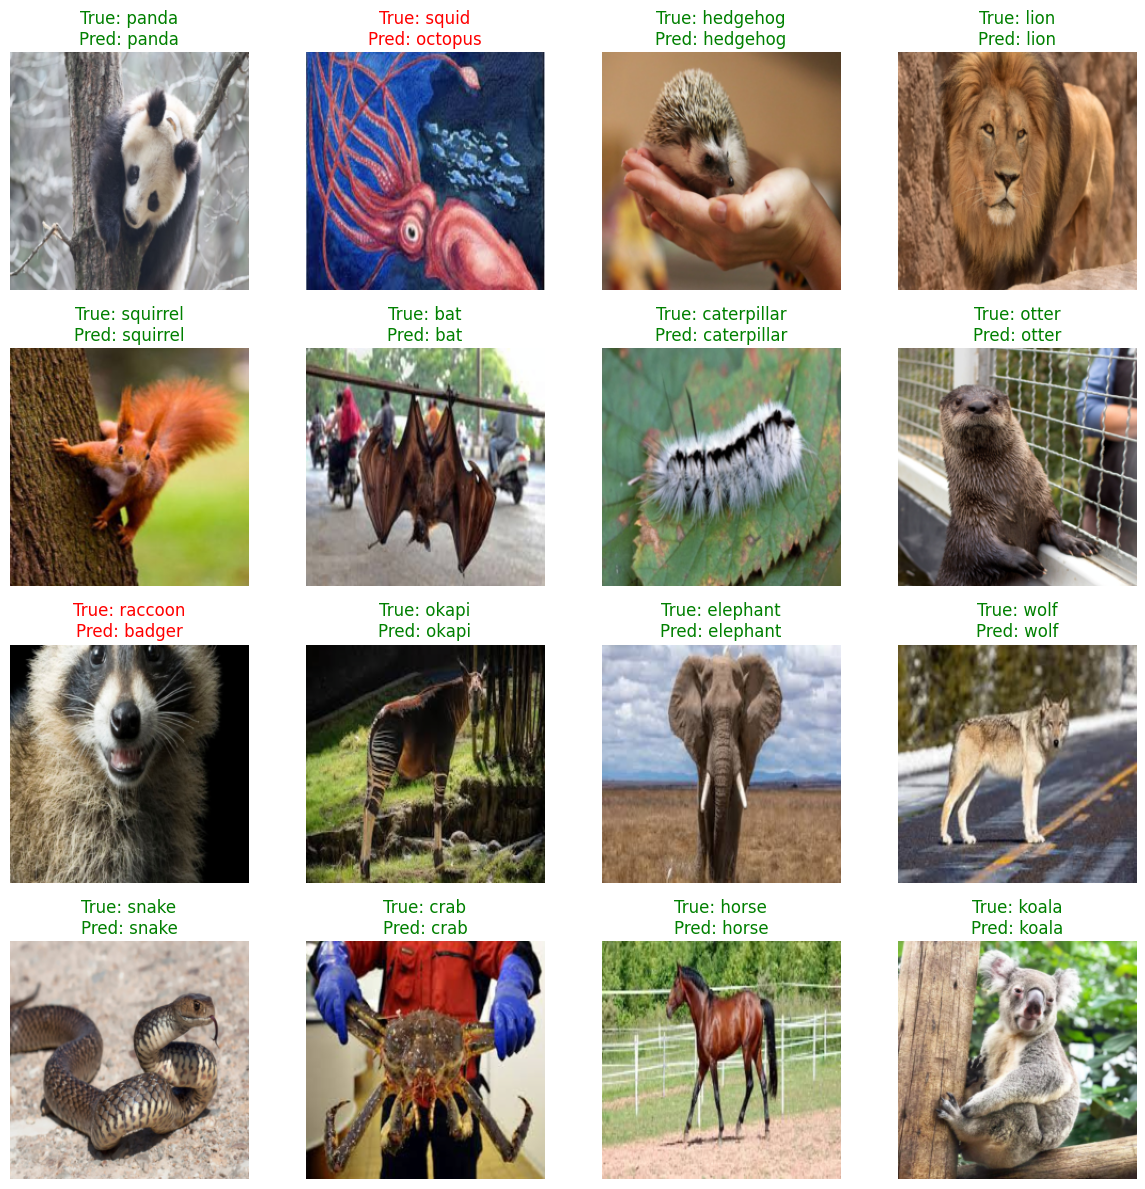

In [37]:
num_samples = 16
indices = np.random.choice(len(val_dataset), size=num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, idx in enumerate(indices):
    image, label = val_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    pred = pred.item()
    
    # Inverse normalization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    ax = axes.flat[i]
    ax.imshow(image_np)
    
    color = 'green' if pred == label else 'red'
    
    # true_label = val_dataset.classes[label]
    # pred_label = val_dataset.classes[pred]
    true_label = dataset.classes[label]
    pred_label = dataset.classes[pred]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()